In [605]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from matplotlib import pyplot
import math

In [606]:
tsData = pd.read_csv('MSFT.csv', index_col='Date', parse_dates=True)
tsData = tsData['Adj Close']
tsData = tsData.dropna()
print(tsData)

Date
2017-09-01     69.787331
2017-09-05     69.475868
2017-09-06     69.277672
2017-09-07     70.164894
2017-09-08     69.825096
                 ...    
2022-02-18    287.929993
2022-02-22    287.720001
2022-02-23    280.269989
2022-02-24    294.589996
2022-02-25    297.309998
Name: Adj Close, Length: 1129, dtype: float64


Plotting the time series chart of USD/INR vs Time

(1129,)


<AxesSubplot:xlabel='Date'>

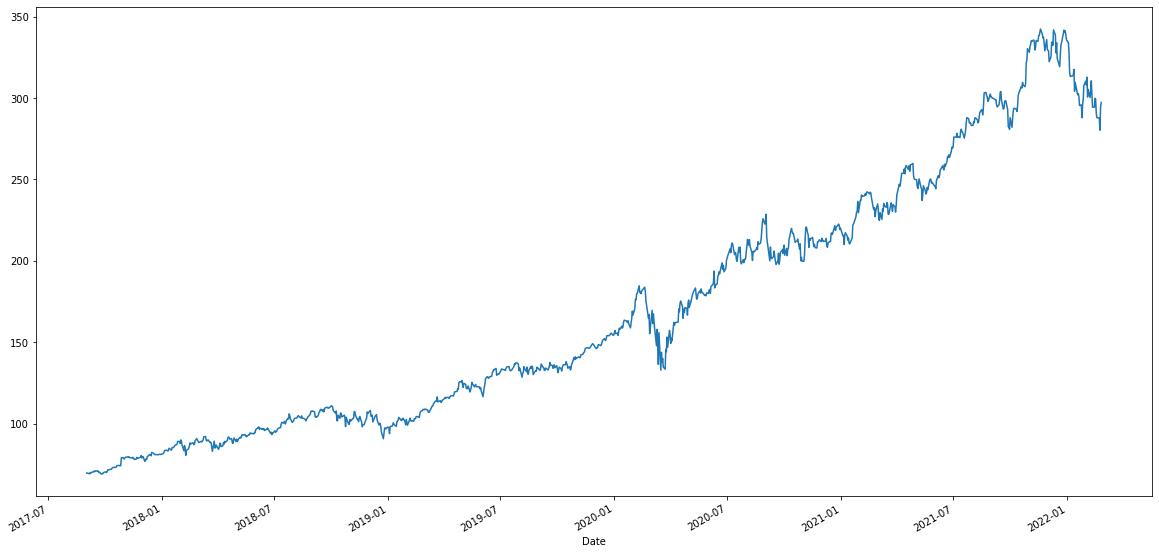

In [607]:
import matplotlib.pyplot as plt

f = plt.figure()
f.set_figwidth(20)
f.set_figheight(10)

print(tsData.shape)
tsData.plot()

Seasonal Decompotion to obtain trend

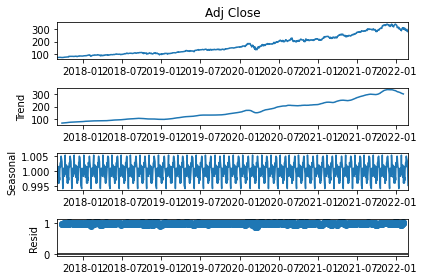

<Figure size 1440x720 with 0 Axes>

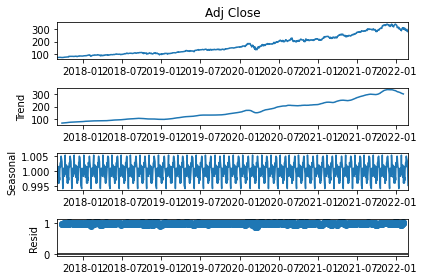

In [608]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

f = plt.figure()
f.set_figwidth(20)
f.set_figheight(10)

decomposedData = seasonal_decompose(tsData, model='multiplicative', period=30)
decomposedData.plot()

<AxesSubplot:xlabel='Date'>

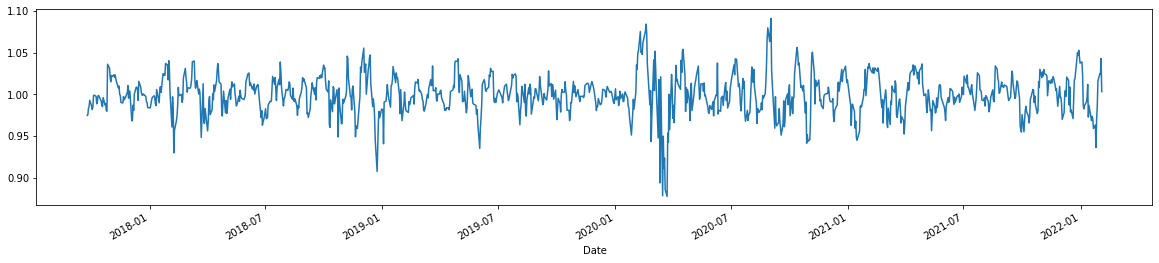

In [609]:
f = plt.figure()
f.set_figwidth(20)
f.set_figheight(4)
decomposedData.resid.plot()

1129


<AxesSubplot:xlabel='Date'>

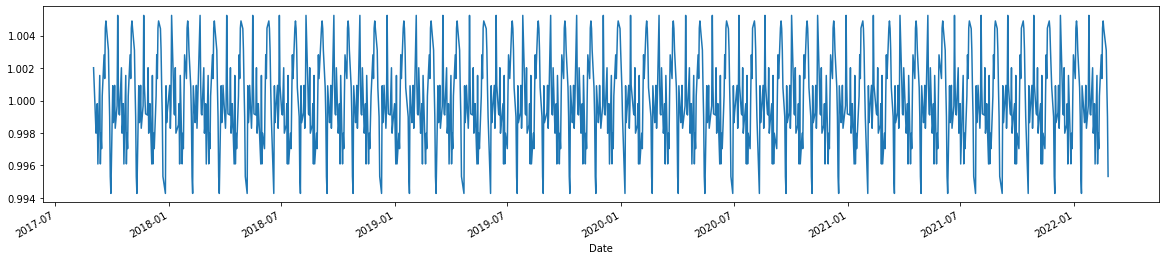

In [610]:
f = plt.figure()
f.set_figwidth(20)
f.set_figheight(4)
print(decomposedData.seasonal.size)
decomposedData.seasonal.plot()

Autocorrelation Test on MSFT data (Durbin Watson)

In [611]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.stattools import durbin_watson
from statsmodels.regression.linear_model import OLS

def DWtest(data):

    plot_acf(data)
    pyplot.show()

    model1 = sm.OLS(data, np.ones(len(data))).fit()
    autoCorr = durbin_watson(model1.resid)
    print('DW Autocorrelation: ', autoCorr)

    if autoCorr == 2:
        print('No autocorrelation')
    elif autoCorr > 1.5 and autoCorr < 2:
        print('Low Positive autocorrelation')
    elif autoCorr >= 0 and autoCorr <= 1.5:
        print('High Positive Autocorrelation')
    elif autoCorr > 2 and autoCorr < 2.5:
        print('Low Negative autocorrelation')
    elif autoCorr >= 2.5 and autoCorr < 4:
        print('High Negative Autocorrelation')  

<Figure size 1440x288 with 0 Axes>

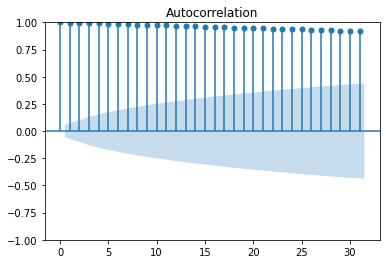

DW Autocorrelation:  0.0017783970714471149
High Positive Autocorrelation


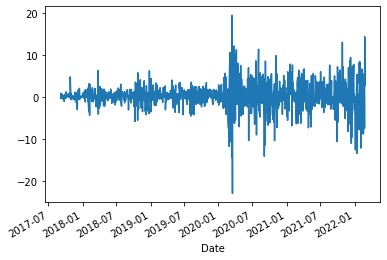

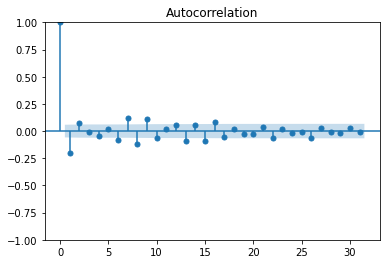

DW Autocorrelation:  2.409606861940675
Low Negative autocorrelation


In [612]:
f = plt.figure()
f.set_figwidth(20)
f.set_figheight(4)

DWtest(tsData)

diff_tsData = tsData.diff()
diff_tsData = diff_tsData.dropna()
diff_tsData.plot()

DWtest(diff_tsData)

Function to find data-points from differences

In [613]:
def findValFromDiff(diffData):
    newData = tsData.copy(deep=True)
    val = newData[0]

    for i in range(len(diffData)):
        if i > 0:
            val += diffData[i-1]
            newData[i] = val

    return newData


Augmented Dickey Fuller Test Function

In [614]:
from statsmodels.tsa.stattools import adfuller

def ADF_test(data):
    ST = adfuller(data, autolag = 'AIC')
    print('ADF: ', ST[0])
    print('P-value: ', ST[1])
    print('No. of Lags: ', ST[2])
    print('No. of observations used: ', ST[3])
    print('Critical Values: ')
    for item, value in ST[4].items():
        print('\t', item, ': ', value)
    
    return ST[1]

Stationarity Test (ADF)

In [615]:
print('ADF Test for dataset\n')
Stationarity_res = ADF_test(tsData)

if Stationarity_res > 0.05 :
    print('\nThe given dataset does not reject H0 hypothesis, hence is non-stationary.')
else:
    print('\nThe given dataset rejects H0 hypothesis, hence is stationary.')

ADF Test for dataset

ADF:  -0.11546172460015794
P-value:  0.9478765428408596
No. of Lags:  9
No. of observations used:  1119
Critical Values: 
	 1% :  -3.436207340777824
	 5% :  -2.8641263411190323
	 10% :  -2.5681470422493593

The given dataset does not reject H0 hypothesis, hence is non-stationary.


In [616]:
print('ADF Test for differenced dataset\n')
Stationarity_res = ADF_test(diff_tsData)

if Stationarity_res > 0.05 :
    print('\nThe given dataset does not reject H0 hypothesis, hence is non-stationary.')
else:
    print('\nThe given dataset rejects H0 hypothesis, hence is stationary.')

ADF Test for differenced dataset

ADF:  -11.21125766449126
P-value:  2.1227579032254033e-20
No. of Lags:  8
No. of observations used:  1119
Critical Values: 
	 1% :  -3.436207340777824
	 5% :  -2.8641263411190323
	 10% :  -2.5681470422493593

The given dataset rejects H0 hypothesis, hence is stationary.


Obtain parameters of ARIMA model

In [617]:
from pmdarima import auto_arima
import warnings
warnings.filterwarnings('ignore')

AIC_result = auto_arima(tsData, trace=True, suppress_warnings=True, seasonal=True, max_order=(3,3,3))
AIC_result.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=5781.072, Time=0.86 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5849.938, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5803.484, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5808.310, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5852.330, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=5805.533, Time=0.22 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=5805.966, Time=0.31 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=5776.653, Time=0.88 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=5796.175, Time=0.50 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=5795.874, Time=1.37 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=1.55 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=5805.976, Time=0.84 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=5806.055, Time=0.49 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=5777.943, Time=1.73 sec
 ARIMA(3,1,2)(0,0,0)[0]             : 

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1129
Model:               SARIMAX(3, 1, 2)   Log Likelihood               -2881.327
Date:                Mon, 28 Feb 2022   AIC                           5776.653
Time:                        19:55:41   BIC                           5811.851
Sample:                             0   HQIC                          5789.952
                               - 1129                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.8569      0.345      2.482      0.013       0.180       1.534
ar.L1         -1.9462      0.045    -42.820      0.000      -2.035      -1.857
ar.L2         -1.1802      0.063    -18.770      0.000      -1.303      -1.057
ar.L3         -0.1302      0.025     -5.128      0.000      -0.180      -0.080
ma.L1          1.7732      0.039     44.929      0.000       1.696       1.851
ma.L2          0.8734      0.037     23.613      0.000       0.801       0.946
sigma2         9.6846      0.238     40.735      0.000       9.219      10.151
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):              1042.23
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):               7.11   Skew:                            -0.46
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.62
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Model ARIMA(3,1,2)

In [618]:
from statsmodels.tsa.arima.model import ARIMA

train = tsData.iloc[: -100]
test = tsData.iloc[-100 :]
print(train.shape, test.shape)
print('Training Data', train)
print('Testing Data', test)

(1029,) (100,)
Training Data Date
2017-09-01     69.787331
2017-09-05     69.475868
2017-09-06     69.277672
2017-09-07     70.164894
2017-09-08     69.825096
                 ...    
2021-09-28    282.418274
2021-09-29    282.896423
2021-09-30    280.824524
2021-10-01    287.976593
2021-10-04    282.009857
Name: Adj Close, Length: 1029, dtype: float64
Testing Data Date
2021-10-05    287.637909
2021-10-06    291.971008
2021-10-07    293.704285
2021-10-08    293.704285
2021-10-11    293.086700
                 ...    
2022-02-18    287.929993
2022-02-22    287.720001
2022-02-23    280.269989
2022-02-24    294.589996
2022-02-25    297.309998
Name: Adj Close, Length: 100, dtype: float64


Training of ARIMA Model

In [619]:
model = ARIMA(train, order=(3,1,2))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              Adj Close   No. Observations:                 1029
Model:                 ARIMA(3, 1, 2)   Log Likelihood               -2543.911
Date:                Mon, 28 Feb 2022   AIC                           5099.822
Time:                        19:55:42   BIC                           5129.434
Sample:                             0   HQIC                          5111.061
                               - 1029                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5084      0.032     16.129      0.000       0.447       0.570
ar.L2         -0.7770      0.030    -25.543      0.000      -0.837      -0.717
ar.L3         -0.2322      0.018    -13.151      0.000      -0.267      -0.198
ma.L1         -0.7339      0.030    -24.543      0.000      -0.792      -0.675
ma.L2          0.9642      0.028     34.046      0.000       0.909       1.020
sigma2         8.2299      0.197     41.672      0.000       7.843       8.617
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):              1582.13
Prob(Q):                              0.80   Prob(JB):                         0.00
Heteroskedasticity (H):               5.51   Skew:                            -0.41
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.02
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Testing of ARIMA Model

In [620]:
start = len(train)
end = len(train) + len(test) - 1
predictions = result.predict(start=start, end=end)
predictions.index = test.index
for num in range(len(predictions)):
    print('Pred: ', predictions[num], ' Actual: ', test[num])

Pred:  282.87049690139537  Actual:  287.637909
Pred:  282.07274282871674  Actual:  291.971008
Pred:  282.38407248000783  Actual:  293.704285
Pred:  282.96232565097324  Actual:  293.704285
Pred:  283.19969854685564  Actual:  293.0867
Pred:  282.79881012440427  Actual:  291.741913
Pred:  282.27626975076566  Actual:  295.158569
Pred:  282.2669409804832  Actual:  301.573547
Pred:  282.76128674580536  Actual:  303.027893
Pred:  283.14122537642953  Actual:  306.095947
Pred:  282.95248007824387  Actual:  307.032288
Pred:  282.446518753221  Actual:  306.215454
Pred:  282.2476855007765  Actual:  309.55246
Pred:  282.58353401859165  Actual:  307.958649
Pred:  283.02627398167965  Actual:  306.932678
Pred:  283.03661276788046  Actual:  308.904938
Pred:  282.61988608459495  Actual:  321.914215
Pred:  282.2971587673136  Actual:  323.08963
Pred:  282.45445099729386  Actual:  330.33136
Pred:  282.8819444757022  Actual:  328.090118
Pred:  283.0520336341075  Actual:  331.83551
Pred:  282.76984106183124 

<AxesSubplot:xlabel='Date'>

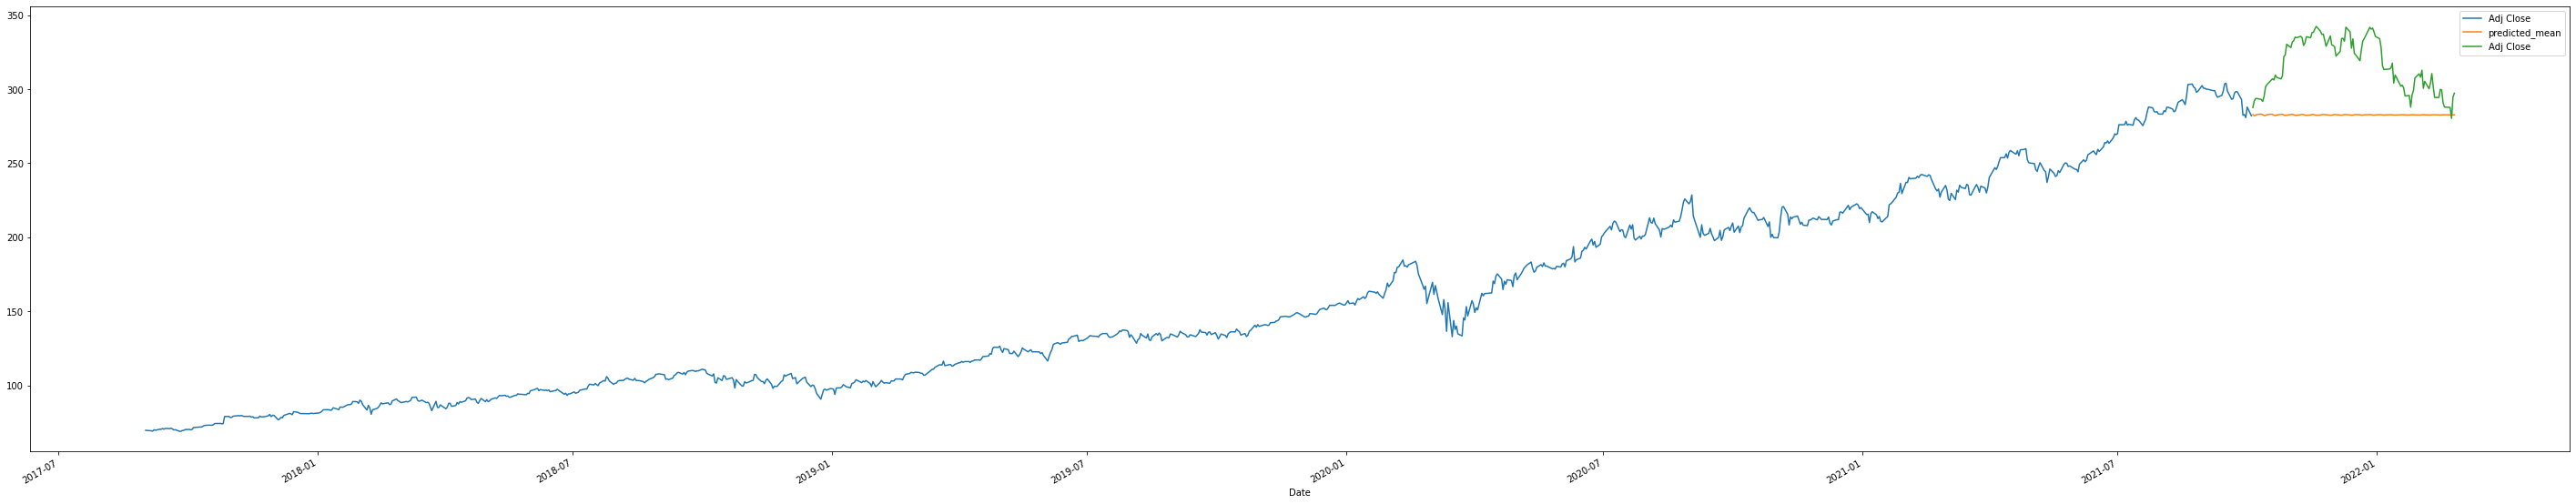

In [621]:
f = plt.figure()
f.set_figwidth(50)
f.set_figheight(10)

train.plot(legend=True)
predictions.plot(legend=True)
test.plot(legend=True)

In [622]:
from sklearn.metrics import mean_squared_error
from math import sqrt

mean_test = test.mean()
sq_mse = sqrt(mean_squared_error(predictions, test))
print('Mean: ', mean_test, ' and MSE: ', sq_mse)
print('Percentage error: ', 100*sq_mse/mean_test)

Mean:  316.49988769000004  and MSE:  38.00042373848452
Percentage error:  12.006457258431805


<AxesSubplot:xlabel='Date'>

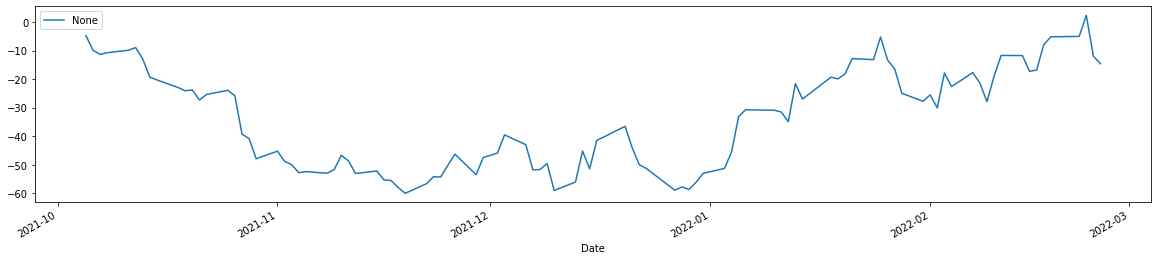

In [623]:
residuals = predictions - test
f = plt.figure()
f.set_figwidth(20)

residuals.plot(legend=True)